## Определение тональности текстов отзывов на сайте YELP сетью LSTM

## Загрузка набора данных

In [ ]:
!wget https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1 -O yelp_review_polarity_csv.tgz
#!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz -O yelp_review_full_csv.tgz

--2020-08-19 08:01:39--  https://www.dropbox.com/s/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz [following]
--2020-08-19 08:01:40--  https://www.dropbox.com/s/dl/ufbhk3kadtnn6h0/yelp_review_polarity_csv.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc45c9a22cc4a81d1d088e4d700c.dl.dropboxusercontent.com/cd/0/get/A9vvqnORZXkJbRbG0KsiTW_t36vAQaTbqTvPCmWzqC8ux_eTJu8w7ddAtXKctto68qikJgcqn7omMJINkUqbYc2uokYho4qeu41N_sfY6DZXT10XjI2mToak_HlZqOt3fA4/file?dl=1# [following]
--2020-08-19 08:01:40--  https://uc45c9a22cc4a81d1d088e4d700c.dl.dropboxusercontent.com/cd/0/get/A9vvqnORZXkJbRbG0KsiTW_t36vAQaTbqTvPCmWzqC8ux_eTJu8w7ddAtXKctto6

In [ ]:
!tar -xvf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


In [ ]:
!tar -xvf yelp_review_full_csv.tgz

tar: yelp_review_full_csv.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


##Начало

In [ ]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Input,Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
num_words = 10000
# максимальное количество слов из отзыва для использования
max_review_len = 100
# максимальное количество уникальных слов
embed_size = 100

## Загружаем данные в память

Читаем данные из файла

In [ ]:
train = pd.read_csv('yelp_review_polarity_csv/train.csv', 
                    header=None, 
                    names=['Class', 'Review'])
train = train.sample(frac = 1., random_state = 42) #перемешиваем данные

In [ ]:
train.head()

,Class,Review
34566,2,This place is one of my favorite comic shops. ...
223092,1,The wait time for an appointment is ridiculous...
110270,1,I did not like this hotel at all. It's very ol...
365013,2,Mill Avenue has a serious issue with parking. ...
311625,2,Favorite sushi place in NV! Price is reasonab...


Выделяем данные для обучения

In [ ]:
reviews = train['Review']

Выделяем правильные ответы

In [ ]:
y_train = train['Class'] - 1

## Токенизация текста

Создаем токенизатор Keras

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на отзывах Yelp

In [ ]:
tokenizer.fit_on_texts(reviews)

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Просматриваем словарь токенизатора

Преобразуем отзывы Yelp в числовое представление

In [ ]:
sequences = tokenizer.texts_to_sequences(reviews)

Просматриваем отзывы в числовом представлении

In [ ]:
index = 0
print(reviews[index])
print(sequences[index])

Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
[16, 31, 11, 44, 7, 14, 303, 6497, 1228, 3, 247, 523, 1644, 4, 5, 246, 44, 17, 3, 500, 4, 2382, 40, 4, 58, 4, 16, 44, 3, 38, 55, 342, 2, 47, 19, 23, 1, 1242, 1624, 20, 75, 43, 67, 989, 1855, 1, 129, 11, 2301, 161, 2, 3, 392, 128, 387, 36, 18, 858, 3, 192, 19, 84, 23, 67, 409, 2251, 50, 46, 4, 46, 2, 112, 266, 55, 256, 4, 30, 698, 2, 3124, 4, 80, 6497, 12

In [ ]:
tokenizer.word_index['frustration']

4339

Ограничиваем длину отзывов

In [ ]:
x_train = pad_sequences(sequences, maxlen=max_review_len)

## Загружаем набор данных для тестирования

In [ ]:
test = pd.read_csv('yelp_review_polarity_csv/test.csv', 
                    header=None, 
                    names=['Class', 'Review'])

Преобразуем отзывы в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])

In [ ]:
x_test = pad_sequences(test_sequences, maxlen=max_review_len)

Правильные ответы

In [ ]:
y_test = test['Class'] - 1

## Создаем нейронную сеть

In [ ]:
pip install keras-metrics

In [ ]:
import keras
import keras_metrics

In [ ]:
inp = Input(shape = (max_review_len,))
x=Embedding(num_words, embed_size, input_length=max_review_len)(inp)
x=LSTM(40,return_sequences=True)(x)
x=Dropout(0.2)(x) # отключаем 20% нейронов на слое
x=GRU(40)(x)
outp =Dense(1, activation='sigmoid')(x)

model = Model(inputs = inp, outputs = outp)

checkpoint_callback = ModelCheckpoint('best_model.hdf5', 
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1) #сохраняем лучшие веса
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3) # функция выхода из обучения

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',
                       keras_metrics.recall()]
              )

## Обучаем нейронную сеть

In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=5,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[earlystop, checkpoint_callback])

Epoch 1/5
875/875 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9069 - recall: 0.8786
Epoch 00001: val_loss improved from inf to 0.18054, saving model to best_model.hdf5
875/875 [==============================] - 89s 101ms/step - loss: 0.2278 - accuracy: 0.9069 - recall: 0.8786 - val_loss: 0.1805 - val_accuracy: 0.9296 - val_recall: 0.9324
Epoch 2/5
875/875 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9394 - recall: 0.9363
Epoch 00002: val_loss improved from 0.18054 to 0.15398, saving model to best_model.hdf5
875/875 [==============================] - 88s 101ms/step - loss: 0.1556 - accuracy: 0.9394 - recall: 0.9363 - val_loss: 0.1540 - val_accuracy: 0.9399 - val_recall: 0.9406
Epoch 3/5
875/875 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9502 - recall: 0.9500
Epoch 00003: val_loss improved from 0.15398 to 0.14968, saving model to best_model.hdf5
875/875 [==============================] - 88s 101ms/step - 

Загружаем модель с лучшей долей правильных ответов на проверочном наборе данных

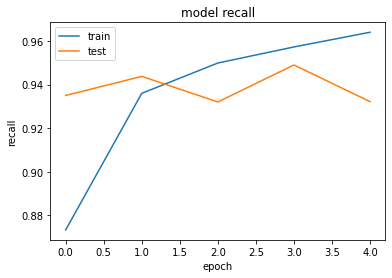

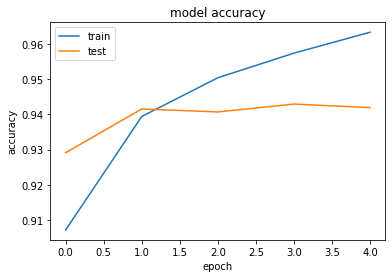

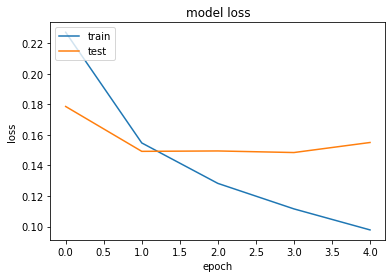

In [ ]:
# summarize history for precision
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Оцениваем качество работы сети на тестовом наборе данных

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

1188/1188 [==============================] - 22s 18ms/step - loss: 0.1537 - accuracy: 0.9415 - recall: 0.9259


[0.15367324650287628, 0.9415000081062317, 0.925850510597229]

## Оцениваем тональность на собственном отзыве

In [ ]:
text = '''The SmartBurger restaurant is awful. It’s a small shabby place. 
The food is really bad and very expensive.  The host and waiters are rude. 
I will never visit the SmartBurger again!
'''

In [ ]:
sequence = tokenizer.texts_to_sequences([text])

In [ ]:
data = pad_sequences(sequence, maxlen=max_review_len)

In [ ]:
result = model.predict(data)

In [ ]:
result

array([[0.00027]], dtype=float32)

In [ ]:
if result[[0]] < 0.5:
    print('Отзыв отрицательный')
else:
    print('Отзыв положительный')

Отзыв отрицательный
